In [1]:

"""
2D Poisson Equation
    Spatial: Iterative solvers (FFT/FST)
"""
import sys
import numpy as np
import scipy
from numba import jit,float64,int64

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import scipy.sparse
import numpy.linalg
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [2]:
@jit(float64(float64[:,:]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [3]:
@jit
def GaussSeidelPoisson(fA, dX, dY, mA, nA, Nx, Ny, uIni):
    tol=1e-10
    maxIter=100000
    d = -2/dX**2 -2/dY**2
    u = uIni*1
    r = fA*0
    numIter = 0
    relError = tol+1
    for iter in range(maxIter):
        if (iter%5000==0):
            print(iter, relError)
        for i in np.arange(1,Nx-1):
            for j in np.arange(1,Ny-1):
                r[i,j] = fA[i,j] - (u[i+1,j]+u[i-1,j] - 2*u[i,j])/dX**2 - (u[i,j+1]+u[i,j-1] - 2*u[i,j])/dY**2
                u[i,j] = u[i,j]+r[i,j]/d
        relError = rms(r)/np.abs(d)
        if relError<tol:
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    print(iter, relError)
    return u


In [4]:
@jit
def ConjugateGradient(fA, dX, dY, mA, nA, Nx, Ny, uIni):
    tol=1e-10
    maxIter=100000
    d = -2/dX**2 -2/dY**2
    u = uIni*1
    r = fA*0
    numIter = 0
    relError = tol+1
    for iter in range(maxIter):
        if (iter%500==0):
            print(iter, relError)
        for i in np.arange(1,Nx-1):
            for j in np.arange(1,Ny-1):
                r[i,j] = fA[i,j] - (u[i+1,j]+u[i-1,j] - 2*u[i,j])/dX**2 - (u[i,j+1]+u[i,j-1] - 2*u[i,j])/dY**2
                u[i,j] = u[i,j]+r[i,j]/d
        relError = rms(r)/np.abs(d)
        if relError<tol:
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    print(iter, relError)
    return u



In [5]:
def ExactSolution(x,y):
    return (x**2-1)*(y**2-1)

def SourceTerm(x,y):
    return -2*(2-x**2-y**2)

In [6]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

numXCen = 512
numYCen = 512
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

uExact = ExactSolution(xMat,yMat)
uBoundary = uExact*1
uBoundary[1:-1,1:-1] = 0

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1,0] - xMat[0,0]
deltaY = yMat[0,1] - yMat[0,0]

rhsF = SourceTerm(xMat, yMat)
u = GaussSeidelPoisson(rhsF, deltaX, deltaY, mMat, nMat, numXGrid, numYGrid, uBoundary)
# u = PoissonFFTCentralDiff(rhsF, deltaX, deltaY, mMat, nMat, numXCen, numYCen)
# u[numXGrid,:] = u[0,:]
# u[:,numYGrid] = u[:,0]



0 1.0000000001
5000 2.2110920390417052e-05
10000 1.3494577939161507e-05
15000 9.855880290579444e-06
20000 7.661154474065802e-06
25000 6.128118494309319e-06
30000 4.9762871139677075e-06
35000 4.075219166103911e-06
40000 3.3535050460532267e-06
45000 2.767325625559112e-06
50000 2.2872989617523004e-06
55000 1.8923068833458206e-06
60000 1.566375100406918e-06
65000 1.2969917743816045e-06
70000 1.074135604418398e-06
75000 8.896691238952435e-07
80000 7.369300595392868e-07
85000 6.104374122744427e-07
90000 5.056691967334303e-07
95000 4.1888844897709755e-07
99999 3.470039436394297e-07


0.009216167903036709


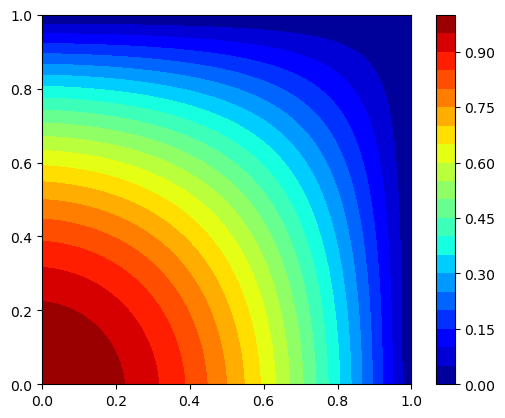

In [10]:
fig,ax = plt.subplots()
cs = ax.contourf(xMat, yMat, u, 20, cmap=cm.get_cmap('jet'))
ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.set_aspect("equal")
cbar = fig.colorbar(cs)


print(rms(u-uExact))
